In [1]:
import os
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler1=StandardScaler()
scaler2=MinMaxScaler()
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

from sklearn.pipeline import Pipeline
 
from sklearn.decomposition import PCA
 
from sklearn.model_selection import TimeSeriesSplit
 
from sklearn.feature_selection import SelectPercentile, f_regression

In [2]:
# Create the DataFrame 'df' with the 'Month' column
# Load the data into a pandas dataframe
df = pd.read_excel('pc_cleaned_2_holiday_season.xlsx')

In [3]:
df.columns

Index(['Datetime', 'Temperature', 'Humidity', 'WindSpeed',
       'GeneralDiffuseFlows', 'DiffuseFlows', 'PowerConsumption_Zone1',
       'PowerConsumption_Zone2', 'PowerConsumption_Zone3', 'Month', 'Day',
       'Hour', 'Minute', 'Holiday', 'Season'],
      dtype='object')

In [4]:
df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')
df.set_index('Datetime', inplace=True)

In [5]:
train, test = df[df['Month']<=10], df[df['Month']>10]

X_train = train[['Temperature','Holiday', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows','DiffuseFlows', 'Month', 'Day', 'Hour', 'Minute', 'Season']]
y_train = np.sqrt(train['PowerConsumption_Zone1'])

X_test = test[['Temperature','Holiday', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'Month', 'Day', 'Hour', 'Minute', 'Season']]
y_test = np.sqrt(test['PowerConsumption_Zone1'])

In [6]:
tscv = TimeSeriesSplit( max_train_size=4320*3, n_splits=8,test_size=4320)# 144 samples per day * 30 days = 4320 samples

In [33]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectPercentile

### minmax scaler

In [81]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(interaction_only=True)),  # Add polynomial features
    ('select', SelectKBest(score_func=f_regression)),  # Add SelectKBest feature selection with f_regression as score function
    ('reg', GradientBoostingRegressor())
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'poly__degree': [2],  # You can choose the desired degree for polynomial features
    'select__k': [7,9,11], 
    'reg__n_estimators': [100, 200, 300],
    'reg__learning_rate': [0.1, 0.05, 0.01],
    'reg__max_depth': [3, 4, 5]
}
# Do the GridSearchCV (Cross-Validation + Hyperparameter Tuning)
model = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=tscv, n_jobs=-1)

In [82]:
model.fit(X_train, y_train)

# Retrieve the best model and print the best hyperparameters
best_model = model.best_estimator_
print("Best Hyperparameters:", model.best_params_)

# Use the best model to predict on the validation fold
y_pred = best_model.predict(X_test)

# Evaluate the performance on the validation fold (e.g., calculate MSE, R-squared, etc.)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("MAE:", mae)
print("R-squared:", r2)

Best Hyperparameters: {'poly__degree': 2, 'reg__learning_rate': 0.01, 'reg__max_depth': 5, 'reg__n_estimators': 300, 'select__k': 9}
MSE: 137.36755466344007
MAE: 10.408998111004069
R-squared: 0.5618032051302757


In [83]:
# Apply the polynomial features transformation on X_train
X_train_poly = best_model.named_steps['poly'].transform(X_train)

# Get the selected features using get_support() method
selected_features_indices = best_model.named_steps['select'].get_support()

# Get the selected features names from PolynomialFeatures
poly_features_names = best_model.named_steps['poly'].get_feature_names_out(X_train.columns)

# Get the selected features from X_train_poly and set column names
selected_features = X_train_poly[:, selected_features_indices]
selected_features_df = pd.DataFrame(selected_features, columns=poly_features_names[selected_features_indices])

# Print the selected features
print("Selected Features:")
print(selected_features_df)

Selected Features:
       Temperature  Hour  Temperature Hour  Humidity Hour  WindSpeed Hour  \
0            6.559   0.0              0.00           0.00           0.000   
1            6.414   0.0              0.00           0.00           0.000   
2            6.313   0.0              0.00           0.00           0.000   
3            6.121   0.0              0.00           0.00           0.000   
4            5.921   0.0              0.00           0.00           0.000   
...            ...   ...               ...            ...             ...   
43771       17.330  23.0            398.59        1365.51           1.886   
43772       17.490  23.0            402.27        1347.11           1.909   
43773       17.390  23.0            399.97        1329.63           1.794   
43774       17.290  23.0            397.67        1328.02           1.794   
43775       17.170  23.0            394.91        1334.23           1.794   

       Month Hour  Day Hour  Hour Minute  Hour Season  


C:\Users\Hooi Ing Teoh\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


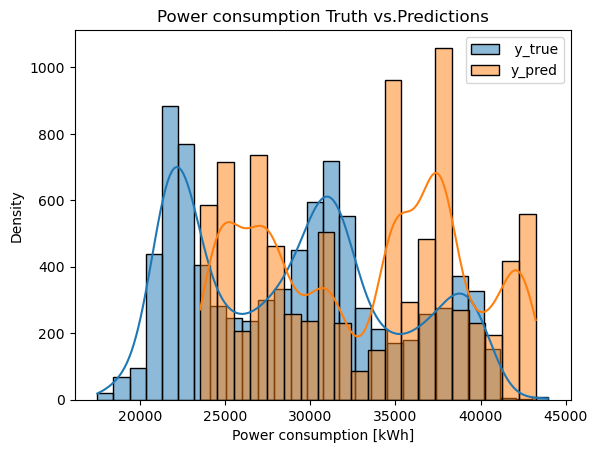

In [75]:
# Histplot of The actudal and the predicted grades
import seaborn as sns
import matplotlib.pyplot as plt


sns.histplot(y_test**2, label=' y_true', kde=True, line_kws={'color': 'green'})
sns.histplot(y_pred**2, label='y_pred', kde=True, line_kws={'color': 'red'})

# Set plot labels and title
plt.xlabel('Power consumption [kWh]')
plt.ylabel('Density')
plt.title('Power consumption Truth vs.Predictions')

# Set the y-axis tick locations and labels
#plt.xticks([i/2 for i in range(21)])

#plt.xlim(15000, 45000)

# Add legend
plt.legend()

# Display the plot
plt.show()

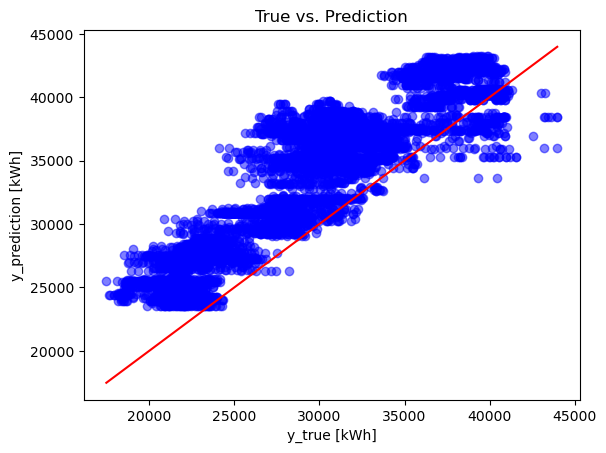

In [76]:
# Plot actual Vs. Predicted 



import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot
plt.scatter(y_test**2, y_pred**2, color='blue', alpha=0.5)

# Add a diagonal line indicating perfect predictions
plt.plot([min(y_test**2), max(y_test**2)], [min(y_test**2), max(y_test**2)], color='red')

# Set plot labels and title
plt.xlabel('y_true [kWh]')
plt.ylabel('y_prediction [kWh]')
plt.title('True vs. Prediction')


# Display the plot
plt.show()

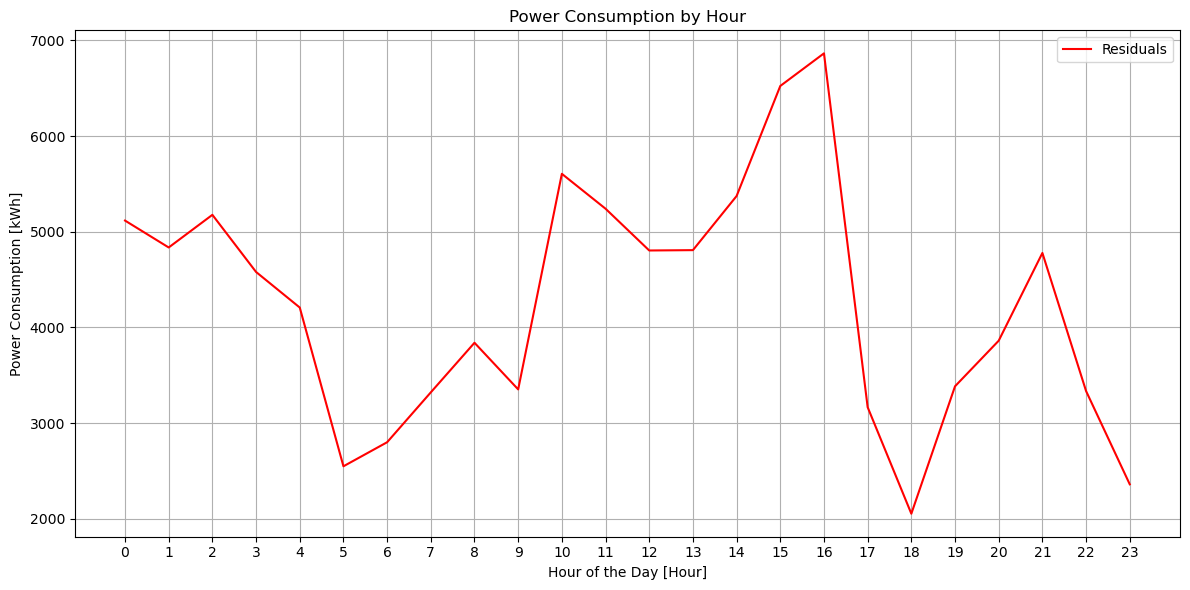

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the residuals (difference between y_pred and y_test)
residuals = abs(y_pred**2 - y_test**2)

# Group the residuals by hour and calculate the mean
residuals_by_hour = residuals.groupby(X_test['Hour']).mean()

# Get the unique hours
hours = np.sort(X_test['Hour'].unique())



# Create a figure
fig, ax = plt.subplots(figsize=(12, 6))


# Plot the residual line
ax.plot(hours, residuals_by_hour.values, label='Residuals', color='red')

# Set labels and titles
ax.set_xlabel('Hour of the Day [Hour]')
ax.set_ylabel('Power Consumption [kWh]')
ax.set_title('Power Consumption by Hour')

# Set x-axis tick locations and labels
ax.set_xticks(hours)
ax.set_xticklabels([str(h) for h in hours])

# Set legend
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


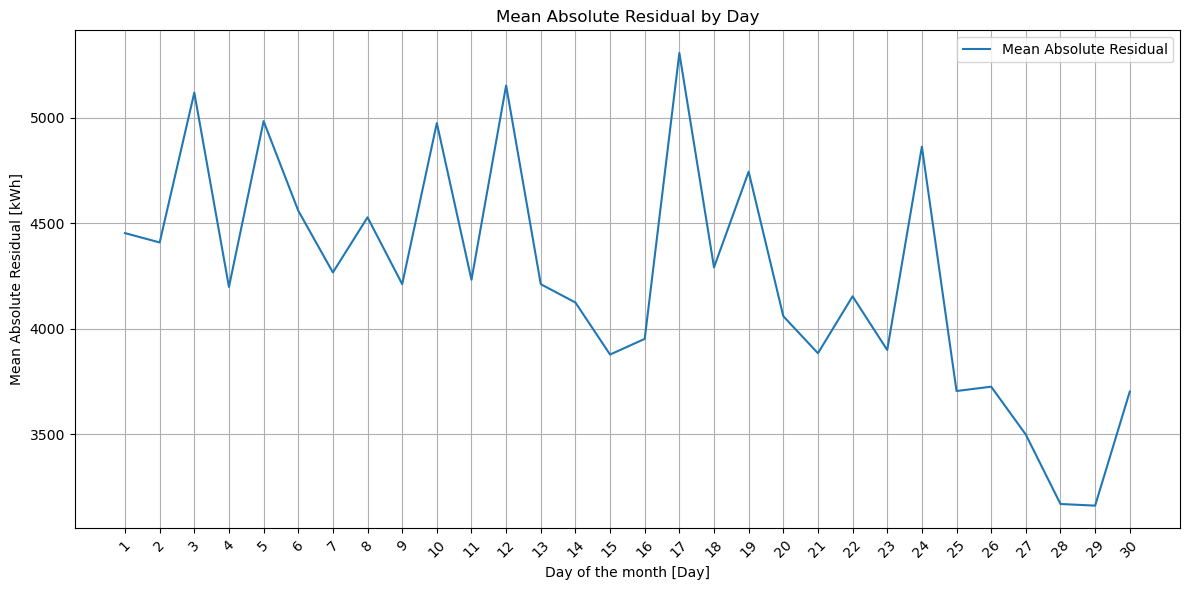

In [78]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the residuals (difference between y_pred and y_test)
residuals = abs(y_pred**2 - y_test**2)

# Create a DataFrame with the daily data and residuals
daily_data = pd.DataFrame({'Day': X_test['Day'], 'Residuals': abs(residuals)})

# Group the data by 'Day' and calculate the mean absolute residual
mean_abs_residuals = daily_data.groupby('Day')['Residuals'].mean()

# Get the unique days
days = mean_abs_residuals.index

# Create a figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the mean absolute residual against the 'Day'
ax.plot(days, mean_abs_residuals.values, label='Mean Absolute Residual')

# Set labels and title
ax.set_xlabel('Day of the month [Day]')
ax.set_ylabel('Mean Absolute Residual [kWh]')
ax.set_title('Mean Absolute Residual by Day')

# Set x-axis tick labels
ax.set_xticks(days)
ax.set_xticklabels([str(day) for day in days], rotation=45)

# Set legend
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Assuming you already have the 'y_pred' array with predictions

# Create a DataFrame from y_pred
predictions_df = pd.DataFrame({'Predicted_PowerConsumption_Zone1': y_pred})

# Load the test DataFrame with the 'Month' column to extract other information for predictions
test_df = pd.read_excel('pc_cleaned_2_holiday_season.xlsx')

# Add the relevant columns from the test data to the predictions DataFrame
predictions_df['Month'] = test_df.loc[test_df['Month'] > 10, 'Month']
predictions_df['Day'] = test_df.loc[test_df['Month'] > 10, 'Day']
predictions_df['Hour'] = test_df.loc[test_df['Month'] > 10, 'Hour']
predictions_df['Minute'] = test_df.loc[test_df['Month'] > 10, 'Minute']
predictions_df['Season'] = test_df.loc[test_df['Month'] > 10, 'Season']

# Save the predictions DataFrame to Excel
predictions_df.to_excel('0-GBR-poly-rfe-predictions.xlsx', index=False)


## GBR with only RFE as comparison

In [49]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
     ("select", SelectPercentile(f_regression)),  # Add SelectKBest feature selection with f_regression as score function
    ('reg', GradientBoostingRegressor())
])

# Define the parameter grid for GridSearchCV
param_grid = {
        "select__percentile": [0.1, 0.25, 0.5, 0.75, 0.9, 1.0],  # You can choose the desired number of top features to keep
    'reg__n_estimators': [100, 200, 300],
    'reg__learning_rate': [0.1, 0.05, 0.01],
    'reg__max_depth': [3, 4, 5]
}
# Do the GridSearchCV (Cross-Validation + Hyperparameter Tuning)
model = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=tscv)

In [50]:
model.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=12960, n_splits=8, test_size=4320),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('select',
                                        SelectPercentile(score_func=<function f_regression at 0x000001E55FFD6200>)),
                                       ('reg', GradientBoostingRegressor())]),
             param_grid={'reg__learning_rate': [0.1, 0.05, 0.01],
                         'reg__max_depth': [3, 4, 5],
                         'reg__n_estimators': [100, 200, 300],
                         'select__percentile': [0.1, 0.25, 0.5, 0.75, 0.9,
                                                1.0]})

In [51]:
# Retrieve the best model and print the best hyperparameters
best_model = model.best_estimator_
print("Best Hyperparameters:", model.best_params_)

# Use the best model to predict on the validation fold
y_pred2 = best_model.predict(X_test)


Best Hyperparameters: {'reg__learning_rate': 0.01, 'reg__max_depth': 5, 'reg__n_estimators': 300, 'select__percentile': 0.1}


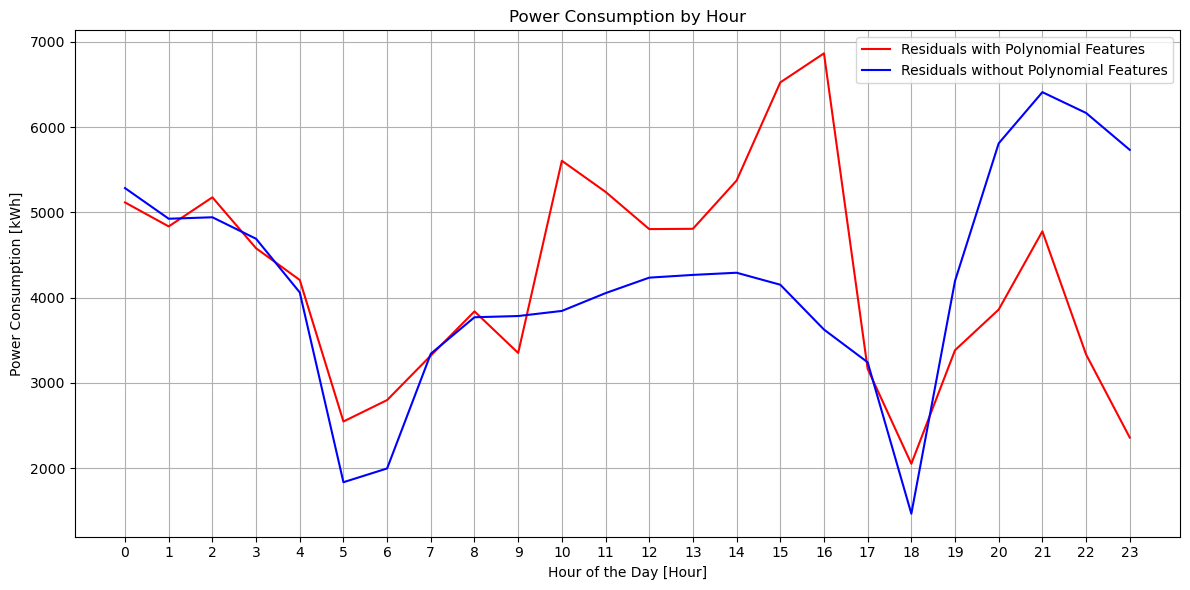

In [79]:
import matplotlib.pyplot as plt


residuals_with_poly = abs(y_pred**2 - y_test**2)


residuals_without_poly = abs(y_pred2**2 - y_test**2)

# Group the residuals by hour and calculate the mean
residuals_by_hour_with_poly = residuals_with_poly.groupby(X_test['Hour']).mean()
residuals_by_hour_without_poly = residuals_without_poly.groupby(X_test['Hour']).mean()

# Get the unique hours
hours = np.sort(X_test['Hour'].unique())

# Create a figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the residuals after RFE
ax.plot(hours, residuals_by_hour_with_poly.values, label='Residuals with Polynomial Features', color='red')

# Plot the residuals before RFE
ax.plot(hours, residuals_by_hour_without_poly.values, label='Residuals without Polynomial Features', color='blue')

# Set labels and titles
ax.set_xlabel('Hour of the Day [Hour]')
ax.set_ylabel('Power Consumption [kWh]')
ax.set_title('Power Consumption by Hour')

# Set x-axis tick locations and labels
ax.set_xticks(hours)
ax.set_xticklabels([str(h) for h in hours])

# Set legend
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


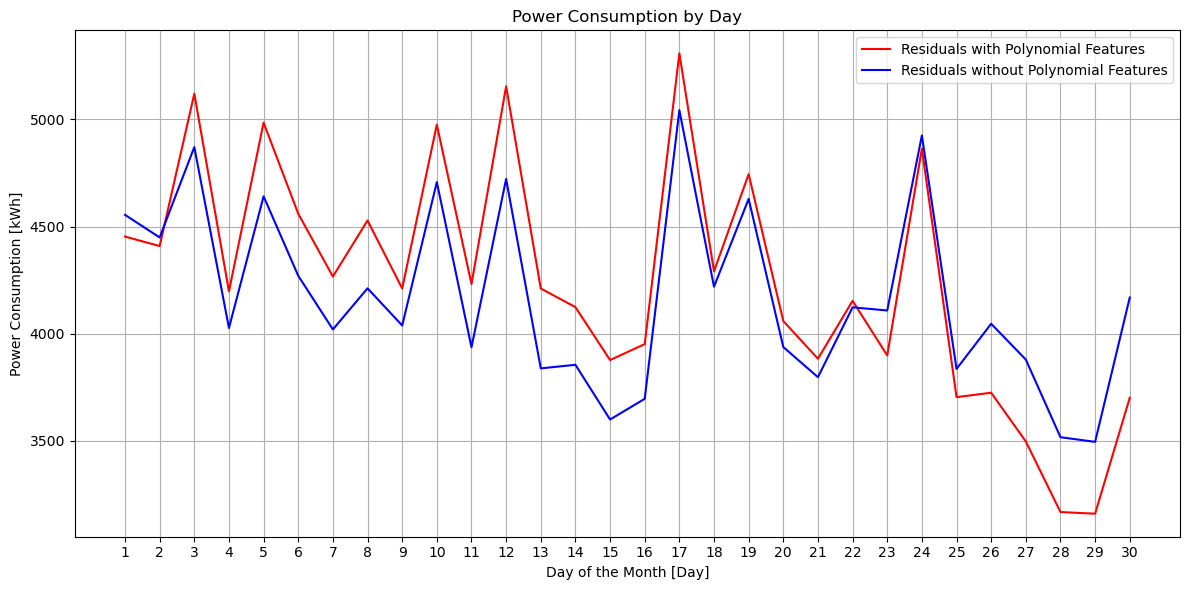

In [80]:
import matplotlib.pyplot as plt

# Calculate the residuals (difference between y_pred and y_test) after RFE
residuals_with_Polynomial_Features = abs(y_pred**2 - y_test**2)

# Calculate the residuals (difference between y_pred2 and y_test2) before RFE
residuals_without_Polynomial_Features  = abs(y_pred2**2 - y_test**2)

# Group the residuals by hour and calculate the mean
residuals_by_day_with_Polynomial_Features = residuals_with_Polynomial_Features.groupby(X_test['Day']).mean()
residuals_by_day_without_Polynomial_Features = residuals_without_Polynomial_Features.groupby(X_test['Day']).mean()

# Get the unique hours
days= np.sort(X_test['Day'].unique())

# Create a figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the residuals after RFE
ax.plot(days, residuals_by_day_with_Polynomial_Features.values, label='Residuals with Polynomial Features', color='red')

# Plot the residuals before RFE
ax.plot(days, residuals_by_day_without_Polynomial_Features.values, label='Residuals without Polynomial Features', color='blue')

# Set labels and titles
ax.set_xlabel('Day of the Month [Day]')
ax.set_ylabel('Power Consumption [kWh]')
ax.set_title('Power Consumption by Day')

# Set x-axis tick locations and labels
ax.set_xticks(days)
ax.set_xticklabels([str(d) for d in days])

# Set legend
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()
